In [1]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow h5py tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\guanc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


# Setup

In [2]:
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/bin")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

### GPU Acceleration
Enable GPU Acceleration if you have a NVIDIA GPU with compute capability >= 7.0

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

## ENABLE THIS IF YOU HAVE RTX GPU WITH COMPUTE CAPABILITY 7.0 or higher
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:1c:00.0, compute capability: 7.5

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


### Loading Data

In [4]:
# pd.set_option('display.max_rows', None)
fp = "./features_combined.csv"
batch_pd = pd.read_csv(fp, index_col=False)
dataset = batch_pd.copy()
dataset.sort_values(by=['policy'], ascending=True, inplace=True)
# dataset
dataset.isna().sum()
dataset = dataset.dropna().drop(columns=['policy', 'barcode'])

In [5]:
## Global Model Config
EPOCHS = 2500
UNITS = 1
LEARNING_RATE = 0.01
CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=15, min_delta=0.01)

## Data split
Split by policy fast charge first(5C - 8C), and then by policy slow charge (1C - 4C)


In [6]:
normal_charge_dataset = dataset.iloc[0:29, :]
fast_charge_dataset = dataset.iloc[29:, :]
print(normal_charge_dataset.shape, fast_charge_dataset.shape)

(29, 15) (51, 15)


## Fast-Charge Test-Train split

In [7]:
fast_charge_train_ds = fast_charge_dataset.iloc[0::2, :]
fast_charge_test_ds = fast_charge_dataset.iloc[1::2, :]
# sns.pairplot(fast_charge_train_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
# sns.pairplot(fast_charge_test_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
# fast_charge_test_ds
fast_charge_train_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle_life,26.0,709.000000,193.796801,462.000000,522.500000,702.000000,871.500000,1053.000000
QD2,26.0,1.075827,0.009765,1.042137,1.071382,1.076585,1.079837,1.094639
QD(Max-2),26.0,0.075046,0.355479,0.003094,0.004385,0.005073,0.006637,1.817914
QD100,26.0,1.078456,0.009938,1.047023,1.074762,1.079679,1.084353,1.095349
QDiffMin,26.0,-1.382534,0.113311,-1.558986,-1.484180,-1.358293,-1.301282,-1.196677
QDiffMean,26.0,-1.727856,0.132935,-1.938902,-1.845678,-1.687956,-1.632366,-1.484179
QDiffVar,26.0,-3.730928,0.231815,-4.099414,-3.917423,-3.678960,-3.560911,-3.367237
QDiffSkew,26.0,-0.938650,0.414006,-1.993884,-1.193384,-0.859011,-0.607692,-0.368971
QDiffKurtosis,26.0,0.103841,0.022956,0.030487,0.091231,0.110055,0.119106,0.134112
QDiffStart,26.0,-4.188883,0.509219,-5.440747,-4.527603,-4.178977,-3.776694,-3.399592


In [8]:
fastcharge_train_features = fast_charge_train_ds.copy()
fastcharge_test_features = fast_charge_test_ds.copy()

train_labels = fastcharge_train_features.pop('cycle_life')
test_labels = fastcharge_test_features.pop('cycle_life')


# Linear Regress
### Layering and Build Model

In [9]:
# Normalize layer
QDiffLinVar = np.array(fastcharge_train_features['QDiffLinVar'])
QDiffLinVar_normalizer = layers.Normalization(input_shape=[1,], axis=None)
QDiffLinVar_normalizer.adapt(QDiffLinVar)

# Input and output layers
variance_model_fast_charge = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(UNITS, input_dim=1 ,activation='relu' ),
    layers.Dense(1, activation='linear', dtype='float32', name='predictions')
])
variance_model_fast_charge.summary()

print("Number of weights after calling the model:", len(variance_model_fast_charge.weights))
print("weights:", len(variance_model_fast_charge.weights))
print("trainable_weights:", len(variance_model_fast_charge.trainable_weights))
print("non_trainable_weights:", len(variance_model_fast_charge.non_trainable_weights))

## Compile the model and make a prediction
variance_model_fast_charge.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
    )

## Making a prediction on first 10 samples
variance_model_fast_charge.predict(QDiffLinVar[:10])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 predictions (Dense)         (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________
Number of weights after calling the model: 7
weights: 7
trainable_weights: 4
non_trainable_weights: 3
1/1 [==============================] - 1s 944ms/step


array([[0.43394384],
       [0.8478169 ],
       [0.0881124 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.27130142],
       [1.2748398 ],
       [0.56959456],
       [0.65783674]], dtype=float32)

### Train the Model

In [10]:
%%time
tf.debugging.set_log_device_placement(True)
history = variance_model_fast_charge.fit(
    fastcharge_train_features['QDiffLinVar'],
    train_labels,
    epochs=EPOCHS,
    verbose=2,
    # callbacks=[CALLBACK],
    validation_data=(fastcharge_test_features['QDiffLinVar'], test_labels)
    )

Epoch 1/2500
1/1 - 1s - loss: 538422.3125 - mae: 708.6618 - val_loss: 447416.0938 - val_mae: 647.1266 - 1s/epoch - 1s/step
Epoch 2/2500
1/1 - 0s - loss: 538422.3125 - mae: 708.6618 - val_loss: 447416.0938 - val_mae: 647.1266 - 37ms/epoch - 37ms/step
Epoch 3/2500
1/1 - 0s - loss: 538422.3125 - mae: 708.6618 - val_loss: 447416.0938 - val_mae: 647.1266 - 40ms/epoch - 40ms/step
Epoch 4/2500
1/1 - 0s - loss: 538422.3750 - mae: 708.6618 - val_loss: 447416.0938 - val_mae: 647.1266 - 45ms/epoch - 45ms/step
Epoch 5/2500
1/1 - 0s - loss: 538422.3750 - mae: 708.6617 - val_loss: 447416.0938 - val_mae: 647.1266 - 43ms/epoch - 43ms/step
Epoch 6/2500
1/1 - 0s - loss: 538422.3125 - mae: 708.6617 - val_loss: 447416.0938 - val_mae: 647.1266 - 43ms/epoch - 43ms/step
Epoch 7/2500
1/1 - 0s - loss: 538422.3125 - mae: 708.6618 - val_loss: 447416.0938 - val_mae: 647.1266 - 46ms/epoch - 46ms/step
Epoch 8/2500
1/1 - 0s - loss: 538422.3125 - mae: 708.6617 - val_loss: 447416.0938 - val_mae: 647.1266 - 46ms/epoch 

,loss,mae,val_loss,val_mae,epoch
0,733.772657,26.620703,668.891691,25.438684,0
1,733.772657,26.620703,668.891691,25.438684,1
2,733.772657,26.620703,668.891691,25.438684,2
3,733.772700,26.620703,668.891691,25.438684,3
4,733.772700,26.620701,668.891691,25.438684,4
...,...,...,...,...,...
2495,109.137908,9.758891,101.581960,9.280701,2495
2496,109.135170,9.758773,101.586396,9.281177,2496
2497,109.132450,9.758654,101.590813,9.281652,2497
2498,109.129743,9.758537,101.575384,9.279823,2498


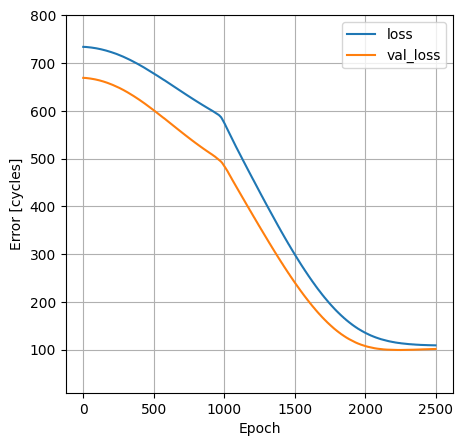

In [11]:
def plot_loss(history):
  plt.figure("BaseMode", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.plot(np.sqrt(history.history['loss']), label='loss')
  plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
  # plt.ylim([200, 130])
  plt.ylim([10, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

## Display model's loss and accuracy history
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist

### Evaluate the Model and Save the Results for comparison

In [12]:
test_results = {}
test_results['fast_charge_variance_model'] = variance_model_fast_charge.evaluate(
    fastcharge_test_features['QDiffLinVar'],
    test_labels, verbose=1) #sqrt for mse
## Based on Author's calculation for MSE
test_results['fast_charge_variance_model'][0] = test_results['fast_charge_variance_model'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'MAE']).T

1/1 [==============================] - 0s 28ms/step - loss: 10318.4473 - mae: 86.1238


,MSE,MAE
fast_charge_variance_model,101.579758,86.123848


### Make Predictions

1/1 [==============================] - 0s 22ms/step


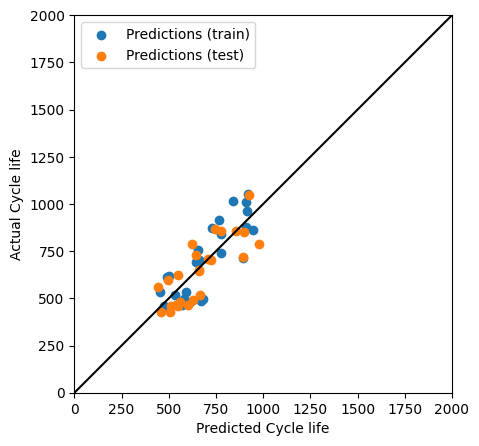

In [13]:
def plot_prediction(y_train, y_test):
  plt.figure("BaseModelPrediction", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.axes(aspect='equal')
  plt.scatter(y_train, train_labels, label='Predictions (train)')
  plt.scatter(y_test, test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

train_prediction = variance_model_fast_charge.predict(fast_charge_train_ds['QDiffLinVar'])
test_prediction = variance_model_fast_charge.predict(fast_charge_test_ds['QDiffLinVar'])
train_prediction
plot_prediction(train_prediction, test_prediction)

# Transfer Learning

### Normal-charge Data Train-Test split

In [14]:
normal_charge_train_ds = normal_charge_dataset.iloc[0::2, :]
normal_charge_test_ds = normal_charge_dataset.iloc[1::2, :]
# sns.pairplot(normal_charge_train_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
# sns.pairplot(normal_charge_test_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')

normalcharge_train_features = normal_charge_train_ds.copy()
normalcharge_test_features = normal_charge_test_ds.copy()

normal_train_labels = normalcharge_train_features.pop('cycle_life')
normal_test_labels = normalcharge_test_features.pop('cycle_life')

### Model Building
Transfer Learning Model

In [15]:
## Make a copy of base model
variance_model_normal_charge_tl = variance_model_fast_charge
## Freezing every layer except the last layer
for layer in variance_model_normal_charge_tl.layers[:-1]:
  layer.trainable = False
variance_model_normal_charge_tl.summary()

variance_model_normal_charge_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 predictions (Dense)         (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 2
Non-trainable params: 5
_________________________________________________________________


Traditional Model

In [16]:
variance_model_normal_charge_traditional = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(UNITS, input_dim=1, activation='relu'),
    layers.Dense(1, activation='linear', dtype='float32', name='predictions')
])
variance_model_normal_charge_traditional.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
    )


### Training the Models

In [17]:
%%time
history_tl = variance_model_normal_charge_tl.fit(
    normalcharge_train_features['QDiffLinVar'],
    normal_train_labels,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(normalcharge_test_features['QDiffLinVar'], normal_test_labels),
    callbacks=[CALLBACK]
    )

Epoch 1/2500
1/1 - 1s - loss: 25699.2773 - mae: 131.9807 - val_loss: 18739.1660 - val_mae: 99.9589 - 713ms/epoch - 713ms/step
Epoch 2/2500
1/1 - 0s - loss: 25634.4629 - mae: 131.7908 - val_loss: 18700.6562 - val_mae: 99.8555 - 40ms/epoch - 40ms/step
Epoch 3/2500
1/1 - 0s - loss: 25569.8496 - mae: 131.6009 - val_loss: 18662.2832 - val_mae: 99.7521 - 38ms/epoch - 38ms/step
Epoch 4/2500
1/1 - 0s - loss: 25505.4375 - mae: 131.4111 - val_loss: 18624.0586 - val_mae: 99.6487 - 37ms/epoch - 37ms/step
Epoch 5/2500
1/1 - 0s - loss: 25441.2422 - mae: 131.2213 - val_loss: 18585.9648 - val_mae: 99.5453 - 41ms/epoch - 41ms/step
Epoch 6/2500
1/1 - 0s - loss: 25377.2461 - mae: 131.0315 - val_loss: 18548.0254 - val_mae: 99.4419 - 40ms/epoch - 40ms/step
Epoch 7/2500
1/1 - 0s - loss: 25313.4746 - mae: 130.8418 - val_loss: 18510.2305 - val_mae: 99.3386 - 36ms/epoch - 36ms/step
Epoch 8/2500
1/1 - 0s - loss: 25249.9238 - mae: 130.6522 - val_loss: 18472.5742 - val_mae: 99.2353 - 41ms/epoch - 41ms/step
Epoch 

In [18]:
%%time
history_traditional = variance_model_normal_charge_traditional.fit(
    normalcharge_train_features['QDiffLinVar'],
    normal_train_labels,
    epochs=EPOCHS,
    verbose=2,
    # callbacks=[CALLBACK],
    validation_data=(normalcharge_test_features['QDiffLinVar'], normal_test_labels))

Epoch 1/2500
1/1 - 1s - loss: 560389.3125 - mae: 679.0618 - val_loss: 395555.7812 - val_mae: 562.7418 - 791ms/epoch - 791ms/step
Epoch 2/2500
1/1 - 0s - loss: 560389.3125 - mae: 679.0618 - val_loss: 395555.7812 - val_mae: 562.7418 - 38ms/epoch - 38ms/step
Epoch 3/2500
1/1 - 0s - loss: 560389.3125 - mae: 679.0618 - val_loss: 395555.7812 - val_mae: 562.7418 - 52ms/epoch - 52ms/step
Epoch 4/2500
1/1 - 0s - loss: 560389.3750 - mae: 679.0618 - val_loss: 395555.7812 - val_mae: 562.7418 - 75ms/epoch - 75ms/step
Epoch 5/2500
1/1 - 0s - loss: 560389.3750 - mae: 679.0618 - val_loss: 395555.7812 - val_mae: 562.7418 - 32ms/epoch - 32ms/step
Epoch 6/2500
1/1 - 0s - loss: 560389.3125 - mae: 679.0618 - val_loss: 395555.7812 - val_mae: 562.7418 - 37ms/epoch - 37ms/step
Epoch 7/2500
1/1 - 0s - loss: 560389.3750 - mae: 679.0618 - val_loss: 395555.7812 - val_mae: 562.7418 - 37ms/epoch - 37ms/step
Epoch 8/2500
1/1 - 0s - loss: 560389.3125 - mae: 679.0618 - val_loss: 395541.1562 - val_mae: 562.7252 - 35ms/

### Plot loss graph and Evaluate

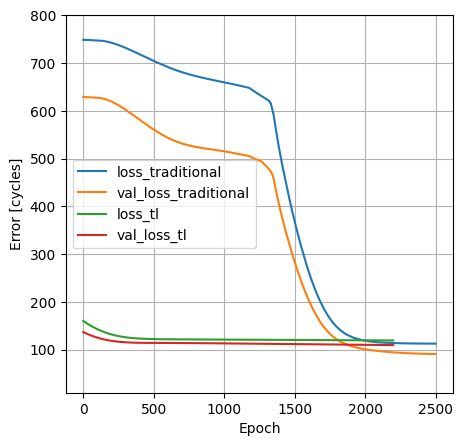

In [19]:
def plot_loss(hist_trad, hist_tl):
  plt.figure("TransferLearning vs Traditional", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.plot(np.sqrt(hist_trad.history['loss']), label='loss_traditional')
  plt.plot(np.sqrt(hist_trad.history['val_loss']), label='val_loss_traditional')
  plt.plot(np.sqrt(hist_tl.history['loss']), label='loss_tl')
  plt.plot(np.sqrt(hist_tl.history['val_loss']), label='val_loss_tl')
  # plt.ylim([200, 130])
  plt.ylim([10, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)

plot_loss(history_traditional, history_tl)

# hist = pd.DataFrame(history_tl.history)
# hist = hist.pow(0.5) # Power 1/2 is the same as square root
# hist['epoch'] = history.epoch
# hist

# hist2 = pd.DataFrame(history_traditional.history)
# hist2 = hist.pow(0.5)
# hist2['epoch'] = history_traditional.epoch
# hist2

In [20]:
test_results['normal_charge_variance_model_tl'] = variance_model_normal_charge_tl.evaluate(
    normalcharge_test_features['QDiffLinVar'],
    normal_test_labels, verbose=1) #sqrt for mse
test_results['normal_charge_variance_model_traditional'] = variance_model_normal_charge_traditional.evaluate(
    normalcharge_test_features['QDiffLinVar'],
    normal_test_labels, verbose=1) #sqrt for mse

1/1 [==============================] - 0s 25ms/step - loss: 8256.7607 - mae: 66.6773


### Make Predictions

1/1 [==============================] - 0s 20ms/step


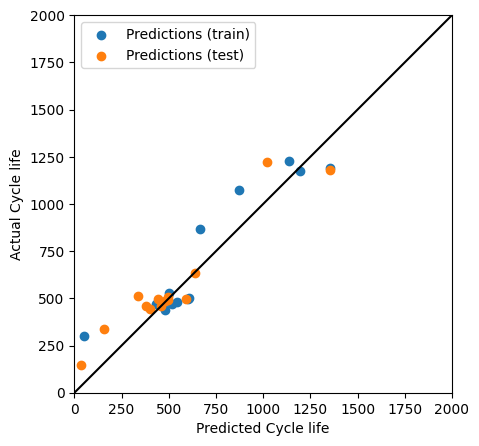

In [21]:
def plot_prediction(y_train, y_test):
  plt.figure("Transfer Learning vs Traditional", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.axes(aspect='equal')
  plt.scatter(y_train, normal_train_labels, label='Predictions (train)')
  plt.scatter(y_test, normal_test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

normal_train_prediction = variance_model_normal_charge_tl.predict(normal_charge_train_ds['QDiffLinVar'])
normal_test_prediction = variance_model_normal_charge_tl.predict(normal_charge_test_ds['QDiffLinVar'])
plot_prediction(normal_train_prediction, normal_test_prediction)

1/1 [==============================] - 0s 20ms/step


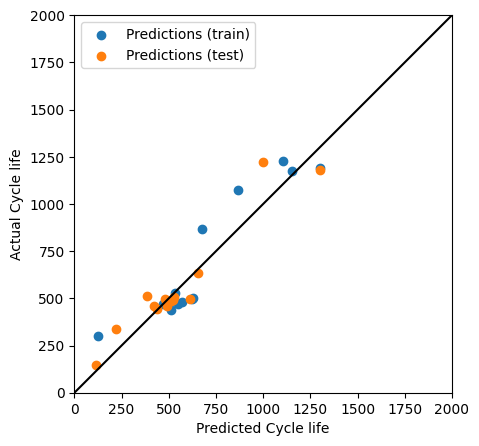

In [22]:
normal_train_prediction2 = variance_model_normal_charge_traditional.predict(normal_charge_train_ds['QDiffLinVar'])
normal_test_prediction2 = variance_model_normal_charge_traditional.predict(normal_charge_test_ds['QDiffLinVar'])
plot_prediction(normal_train_prediction2, normal_test_prediction2)

### Final Results and conclusions

In [23]:
test_results['normal_charge_variance_model_tl'][0] = test_results['normal_charge_variance_model_tl'][0] ** 0.5
test_results['normal_charge_variance_model_traditional'][0] = test_results['normal_charge_variance_model_traditional'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'MAE']).T

,MSE,MAE
fast_charge_variance_model,101.579758,86.123848
normal_charge_variance_model_tl,109.647504,82.014771
normal_charge_variance_model_traditional,90.866720,66.677345


# Scratch Test

In [24]:
# model = tf.keras.Sequential(
#     [
#         layers.Dense(2, activation="relu"),
#         layers.Dense(3, activation="relu"),
#         layers.Dense(4),
#     ]
# ) 
# model.summary()